# Notebook Instructions
<i>You can run the notebook document sequentially (one cell a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

# Mean Reversion Strategy on Oil Crack

In [1]:
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt  
import yfinance
%matplotlib inline

plt.style.use('seaborn-darkgrid')
tickers = ['BZ=F','CL=F','RB=F','NG=F','HO=F','HE=F']
data = yfinance.download(tickers, period='7y', interval='1d')
close_price = data['Close']
df = pd.DataFrame(close_price)
df.dropna(inplace=True)
df = df.drop('20-04-2020')
df.to_csv('yFinance.csv')

C:\Users\mtay\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


[*********************100%***********************]  6 of 6 completed


In [2]:
import yfinance
tickers = ['BZ=F','CL=F','RB=F','NG=F','HO=F','HE=F']
data = yfinance.download(tickers, period='7y', interval='1d')
close_price = data['Close']
df = pd.DataFrame(close_price)
df.dropna(inplace=True)
df = df.drop('20-04-2020')
df.to_csv('yFinance.csv')

[*********************100%***********************]  6 of 6 completed


## OOP Method: Prepare the data and backtest using OLS

In [3]:
class FinancialData:
    url = "yFinance.csv"
    def __init__(self,y_symbol, x_symbol):
        self.y_symbol = y_symbol
        self.x_symbol = x_symbol
        self.retrieve_data()
        self.model_fit()

    def retrieve_data(self):
        self.y = pd.read_csv(self.url, index_col=0)[self.y_symbol] * 42 #5.7 for Natty, 32 for HO and RB
        self.x = pd.read_csv(self.url, index_col=0)[self.x_symbol] 
        self.df = pd.concat([self.y, self.x],axis=1)
        self.df.columns = [self.y_symbol, self.x_symbol]
        self.df.index = pd.to_datetime(df.index)
    
    def model_fit(self):
        # OLS(Y,X)
        import statsmodels.api as sm
        self.model = sm.OLS(self.df[self.y_symbol], self.df[self.x_symbol])
        self.model = self.model.fit() 
        self.df['spread'] = self.df[self.y_symbol] - self.model.params[0] * self.df[self.x_symbol]
        # Plot the spread
        self.df.spread.plot(ylabel = "Spread", figsize=(10,8), color='g', 
                            title= "Spread of %s minus %s. Slope is %.1f" %(self.y_symbol,self.x_symbol,self.model.params[0]))
        plt.show()     
        'The hedge ratio is %.2f' % self.model.params[0]
        
        # To perform ADF Test for stationarity
        from statsmodels.tsa.stattools import adfuller
        # Compute ADF test statistics
        self.adf = adfuller(self.df['spread'], maxlag = 1)
        self.adf[0]
        plt.figure(figsize=(10,7))
        # scatter(X,Y)
        plt.scatter(self.df[self.x_symbol], self.df[self.y_symbol], color='red')
        plt.xlabel(self.x_symbol)
        plt.ylabel(self.y_symbol)
        plt.title("ADF result is %.2f" %self.adf[0])
        plt.show()
        return self.model.params[0]

    def plot_data(self, lookback_period):
        self.lookback_period = lookback_period
        self.df[[self.y_symbol,self.x_symbol]].iloc[self.lookback_period: ].plot(secondary_y='p', figsize=(10,8))
    
    def mean_reversion_strategy(self, lookback, std_dev):
        # Moving Average
        self.df['moving_average'] = self.df['spread'].rolling(lookback).mean()
        # Moving Standard Deviation
        self.df['moving_std_dev'] = self.df['spread'].rolling(lookback).std()
        # Upper band and lower band
        self.df['upper_band'] = self.df['moving_average'] + (std_dev * self.df['moving_std_dev'])
        self.df['lower_band'] = self.df['moving_average'] - (std_dev * self.df['moving_std_dev'])
        # Long positions
        self.df['long_entry'] = self.df['spread'] < self.df['lower_band']
        self.df['long_exit'] = self.df['spread'] >= self.df['moving_average']
        self.df['positions_long'] = np.nan
        self.df.loc[self.df['long_entry'], 'positions_long'] = 1 # Boolean way of using loc
        self.df.loc[self.df['long_exit'], 'positions_long'] = 0 # Boolean way of using loc
        self.df['positions_long'] = self.df['positions_long'].fillna(method='ffill')
        # Short positions
        self.df['short_entry'] = self.df['spread'] > self.df['upper_band']
        self.df['short_exit'] = self.df['spread'] <= self.df['moving_average']
        self.df['positions_short'] = np.nan
        self.df.loc[self.df['short_entry'], 'positions_short'] = -1
        self.df.loc[self.df['short_exit'], 'positions_short'] = 0
        self.df['positions_short'] = self.df['positions_short'].fillna(method='ffill')
        # Positions
        self.df['positions'] = self.df['positions_long'] + self.df['positions_short']


## Call using the OOP Method

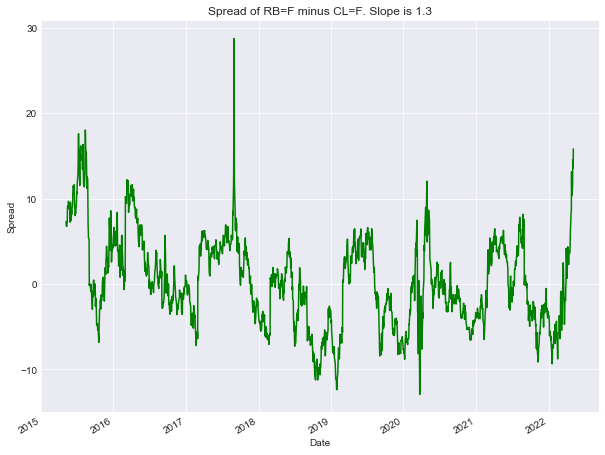

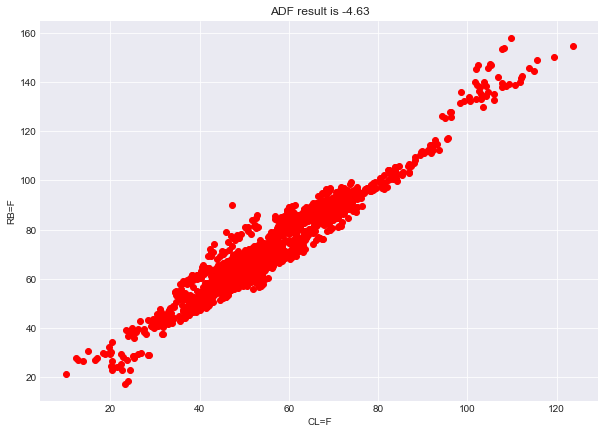

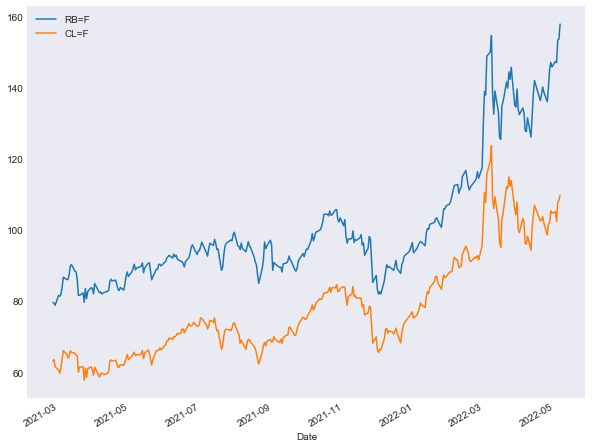

In [4]:
y_symbol = 'RB=F'
x_symbol = 'CL=F'

fd = FinancialData(y_symbol, x_symbol) # Input two variables (y dependent, x independent)
fd.plot_data(lookback_period = -300) # Adjust how much to plot so that chart won't be too small to read

## Mean reversion strategy function

In [5]:
fd.mean_reversion_strategy(lookback=34, std_dev=2) ## Adjust this to find optimum results
df2 = fd.df # Call complete dataset using fd.df
df2.dropna(inplace=True)

## Plot chart

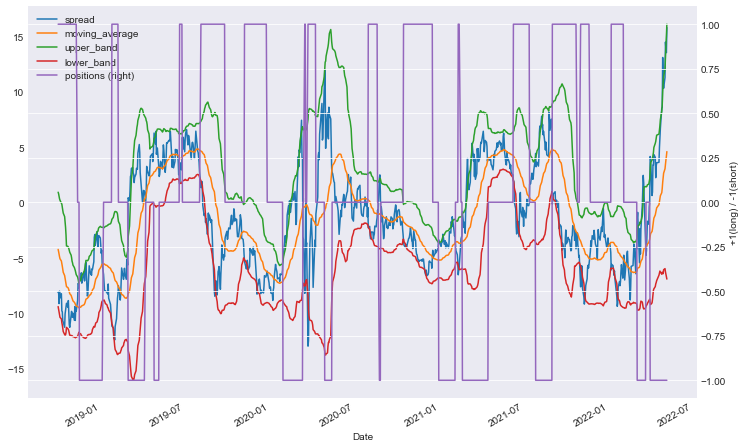

In [6]:
chartlookbackperiod = -900
df3 = df2[['spread','moving_average','upper_band','lower_band','positions']]
df3.iloc[chartlookbackperiod:].plot(figsize=(12,8), secondary_y='positions')
plt.xlabel('Date')
plt.ylabel('+1(long) / -1(short)')
plt.show()

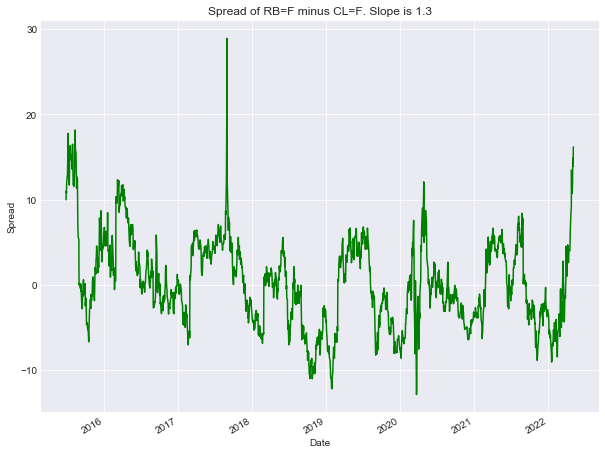

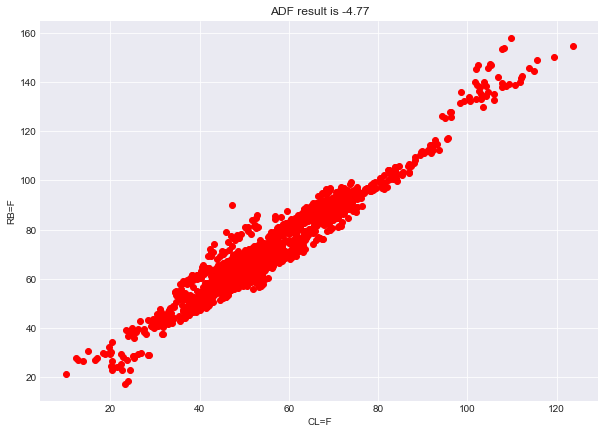

'The total strategy returns are 123.89 pct'

In [7]:
df2['percentage_change'] = (df2.spread - df2.spread.shift(1))/(fd.model_fit()*df2[x_symbol] + df2[y_symbol])
df2['strategy_returns'] = df2.positions.shift(1) * df2.percentage_change
df2['cumulative_returns'] = (df2.strategy_returns+1).cumprod()
"The total strategy returns are %.2f pct" % ((df2['cumulative_returns'].iloc[-1]-1)*100)

In [8]:
s = np.mean(df2['strategy_returns'])/np.std(df2['strategy_returns'])*(252**0.5)
'The Sharpe Ratio %.2f' % s

'The Sharpe Ratio 0.87'

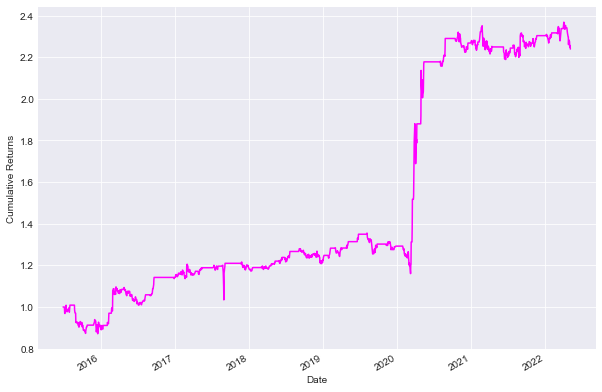

In [9]:
df2.cumulative_returns.plot(label='Returns', figsize=(10,7),color='magenta')  
plt.xlabel('Date')  
plt.ylabel('Cumulative Returns')  
plt.show()

In [10]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()

The maximum drawdown is -14.38


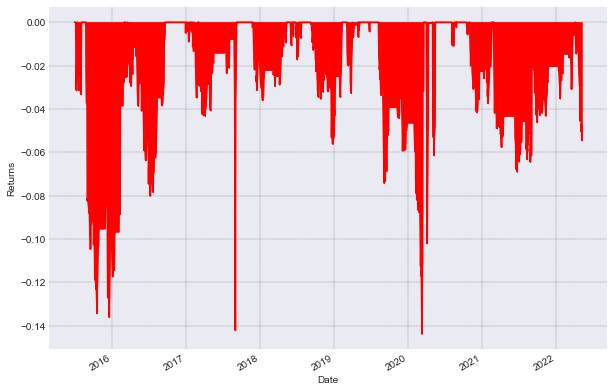

In [11]:
drawdown = calc_drawdown(df2.cumulative_returns)
print("The maximum drawdown is %.2f" % (drawdown.min()*100))
plot_drawdown(drawdown)